In [ ]:
# 2.3 For the advanced environment we are making use of Pong

In [ ]:
# Installing gymnasium
# !pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 6.7 MB/s eta 0:00:00


In [ ]:
# Functions to plot graph
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

def smooth_out_data(data, desired_points=100):
    interval_length = len(data) // desired_points
    if interval_length <= 1:
        return np.arange(len(data)), data

    smoothed_data = [np.mean(data[i:i + interval_length]) for i in range(0, len(data), interval_length)]
    indices = np.linspace(0, len(data), len(smoothed_data), endpoint=False)
    return indices, smoothed_data

def plot_rewards_over_episodes(rewards, desired_points=100):
    plt.figure(figsize=(18, 5))
    indices, smoothed_rewards = smooth_out_data(rewards, desired_points)
    plt.plot(indices, smoothed_rewards, label='Reward per Episode')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.title('Rewards Over Episodes')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_epsilon_over_episodes(epsilons, desired_points=100):
    plt.figure(figsize=(18, 5))
    indices, smoothed_epsilons = smooth_out_data(epsilons, desired_points)
    plt.plot(indices, smoothed_epsilons, label='Epsilon Value')
    plt.xlabel('Episodes')
    plt.ylabel('Epsilon')
    plt.title('Epsilon Decay Over Episodes')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_two_rewards_over_episodes(rewards1, rewards2, rewards3=None, desired_points=100, labels=('Rewards 1', 'Rewards 2')):
    plt.figure(figsize=(18, 5))

    indices1, smoothed_rewards1 = smooth_out_data(rewards1, desired_points)
    plt.plot(indices1, smoothed_rewards1, label=labels[0])

    indices2, smoothed_rewards2 = smooth_out_data(rewards2, desired_points)
    plt.plot(indices2, smoothed_rewards2, label=labels[1])

    if rewards3 is not None:
      indices3, smoothed_rewards3 = smooth_out_data(rewards3, desired_points)
      plt.plot(indices3, smoothed_rewards3, label=labels[2])

    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.title('Comparison of Rewards Over Episodes')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
!pip install gym[atari]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.0 MB/s eta 0:00:00


In [ ]:
!pip install gym[atari,accept-rom-license]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 7.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446659 sha256=d8a11e891f28196e89490c88c6f9f33bef95233dfa9a662b822d251b6a425aa7
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


In [ ]:
!pip install ale-py


In [ ]:
# !pip install autorom
!mkdir /content/roms
!AutoROM --accept-license --install-dir /content/roms

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/content/roms

Existing ROMs will be overwritten.
Installed /content/roms/adventure.bin
Installed /content/roms/air_raid.bin
Installed /content/roms/alien.bin
Installed /content/roms/amidar.bin
Installed /content/roms/assault.bin
Installed /content/roms/asterix.bin
Installed /content/roms/asteroids.bin
Installed /content/roms/atlantis.bin
Installed /content/roms/atlantis2.bin
Installed /content/roms/backgammon.bin
Installed /content/roms/bank_heist.bin
Installed /content/roms/basic_math.bin
Installed /content/roms/battle_zone.bin
Installed /content/roms/beam_rider.bin
Installed /content/roms/berzerk.bin
Installed /content/roms/blackjack.bin
Installed /content/roms/bowling.bin
Installed /content/roms/boxing.bin
Installed /content/roms/breakout.bin
Installed /content/roms/carnival.bin
Installed /content/roms/casino.bin
Installed /content/roms/centipede.bin
Installed /content/roms/chopper_command.bin
Installed /content

In [ ]:
from ale_py import ALEInterface

ale = ALEInterface()
pong_rom_path = '/content/roms/pong.bin'
ale.loadROM(pong_rom_path)


In [ ]:
#Environment setup

#Create environment
from collections import deque
import numpy as np
import gym
import copy
import cv2
cv2.ocl.setUseOpenCL(False)
from gym.wrappers import FrameStack

def make_env(env):
    env = MergeFrame(env, merge=4)
    env = ProcessFrame(env)
    env = FrameStack(env, num_stack=4, new_step_api = True)
    return env

#Used
class ProcessFrame(gym.ObservationWrapper):
    def __init__(self, env, width=80, height=80):
        gym.ObservationWrapper.__init__(self, env)
        self.width = width
        self.height = height

    def observation(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        rows_to_crop = frame.shape[0]//10
        frame_cropped = frame[rows_to_crop:, :]
        frame = cv2.resize(frame_cropped, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame


#This is used to merge 2 frames to provide more context for CNN regarding the state
class MergeFrame(gym.Wrapper):
    def __init__(self, env, merge):
        super(MergeFrame, self).__init__(env)
        self.merge_queue = deque(maxlen=2)
        self.merge = merge

    def step(self, action):
        terminated = False
        truncated = False
        info = {}
        merged_reward= 0.0
        for _ in range(self.merge):
            observation, reward, terminated, truncated, info = self.env.step(action)
            self.merge_queue.append(observation)
            merged_reward += reward

            if terminated or truncated:
                break

        merged_frame = np.max(np.stack(self.merge_queue), axis=0)

        return merged_frame, merged_reward, terminated, truncated, info

    def reset(self):
        self.merge_queue.clear()
        observation = self.env.reset()
        self.merge_queue.append(observation)
        return observation

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


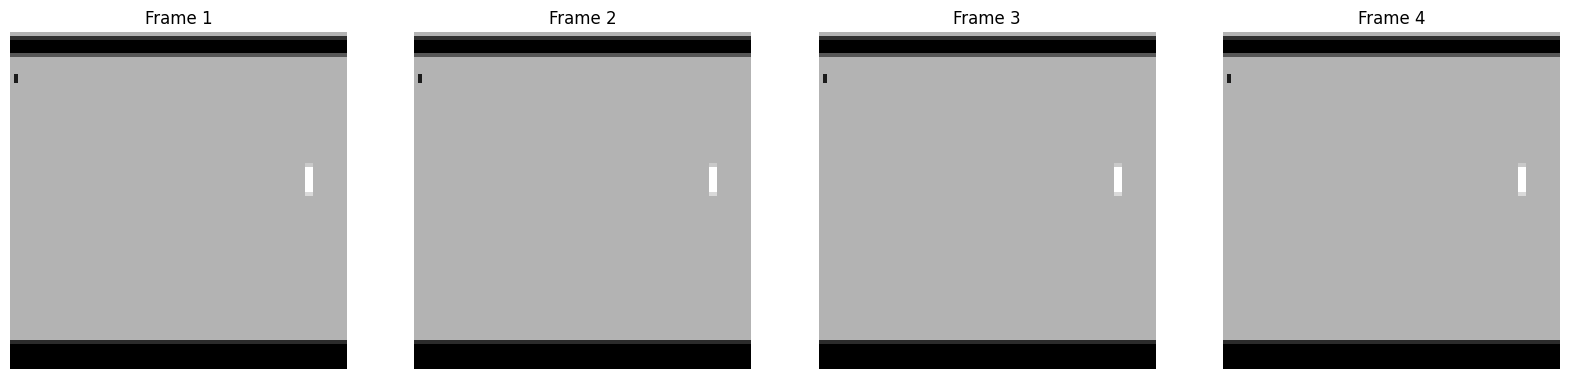

In [ ]:
#Testing
envBase = gym.make("ALE/Pong-v5", new_step_api = True)
env=make_env(envBase)

observation = env.reset()
np_array_sample = np.array(observation)
import numpy as np
import matplotlib.pyplot as plt

state = np_array_sample

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i in range(state.shape[0]):
    axs[i].imshow(state[i], cmap='gray')
    axs[i].title.set_text(f'Frame {i+1}')
    axs[i].axis('off')

plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class PongCNN(nn.Module):
    def __init__(self, action_space, num_stacked_frames=4, dropout_probability=0.1):
        super(PongCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_stacked_frames, 32, kernel_size=8, stride=4, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout2d(p=dropout_probability)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout2d(p=dropout_probability)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout(p=dropout_probability)

        self.fc1_input_size = self._get_conv_output([1, num_stacked_frames, 80, 80])
        self.fc1 = nn.Linear(self.fc1_input_size, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.dropout4 = nn.Dropout(p=dropout_probability)

        self.fc2 = nn.Linear(512, action_space)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout3(x)

        x = torch.flatten(x, start_dim=1)

        x = F.relu(self.bn4(self.fc1(x)))
        x = self.dropout4(x)

        x = self.fc2(x)

        return x

    def _get_conv_output(self, shape):
        with torch.no_grad():
            input = torch.rand(shape)
            output = self._forward_features(input)
        return int(np.prod(output.size()))

    def _forward_features(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout3(x)

        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import torch
import torch.nn.functional as F

def compute_td_loss(policy_net, target_net, experiences, gamma, device):
    states, actions, rewards, next_states, dones = experiences

    states = transform_states(states)
    next_states = transform_states(next_states)

    actions = actions.unsqueeze(-1)
    rewards = rewards.unsqueeze(-1)
    dones = dones.unsqueeze(-1)

    current_q_values = policy_net(states).gather(1, actions)

    next_q_values = target_net(next_states).max(1)[0].detach().unsqueeze(-1)
    expected_q_values = rewards + (gamma * next_q_values * (1 - dones))

    loss = F.smooth_l1_loss(current_q_values, expected_q_values)

    return loss


In [ ]:
import random
from collections import namedtuple, deque
import torch

Experience = namedtuple('Experience', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        e = Experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self, batch_size, device):
        experiences = random.sample(self.memory, k=batch_size)

        states_np = np.array([e.state for e in experiences], dtype=np.float32)
        next_states_np = np.array([e.next_state for e in experiences], dtype=np.float32)

        states = torch.tensor(states_np, dtype=torch.float32).to(device)
        next_states = torch.tensor(next_states_np, dtype=torch.float32).to(device)

        actions = torch.tensor([e.action for e in experiences], dtype=torch.long).to(device)
        rewards = torch.tensor([e.reward for e in experiences], dtype=torch.float32).to(device)
        dones = torch.tensor([e.done for e in experiences], dtype=torch.float32).to(device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)


In [ ]:
def transform_states(states):
  return states

In [ ]:
import torch
import torch.optim as optim
import numpy as np
from itertools import count

envBase = gym.make("ALE/Pong-v5", new_step_api = True)
env=make_env(envBase)

policy_net = PongCNN(action_space=env.action_space.n).to(device)

target_net = PongCNN(action_space=env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)

replay_buffer = ReplayBuffer(50000)

num_episodes = 800
batch_size = 64
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 150
target_update = 4

def epsilon_by_episode(episode):
    return epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * episode / epsilon_decay)

all_episode_rewards = []
epsilons_over_time = []
total_timesteps = 0
for episode in range(num_episodes):
    state = env.reset()

    epsilon = epsilon_by_episode(episode)
    epsilons_over_time.append(epsilon)
    episode_rewards = 0

    for t in count():
        if random.random() > epsilon:
            policy_net.eval()
            with torch.no_grad():
                state_np = np.array(state, dtype=np.float32)
                state_tensor = torch.tensor(state_np, device=device).unsqueeze(0)
                state_tensor = transform_states(state_tensor)
                print(state_tensor)
                print(state_tensor.shape)
                break

                action_values = policy_net(state_tensor)
                action = action_values.max(1)[1].view(1, 1)

        else:
            action = torch.tensor([[random.randrange(env.action_space.n)]], device=device, dtype=torch.long)

        policy_net.train()

        next_state, reward, terminated, truncated, _ = env.step(action.item())
        episode_rewards += reward

        replay_buffer.add(state, action.item(), reward, next_state, terminated or truncated)

        state = next_state

        if len(replay_buffer) > batch_size:
            experiences = replay_buffer.sample(batch_size, device)
            states, actions, rewards, next_states, dones = experiences
            loss = compute_td_loss(policy_net, target_net, experiences, gamma, device)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=1.0)
            optimizer.step()

        if terminated or truncated:
            total_timesteps = total_timesteps + (t+1)
            print(f'Episode {episode} finished after {t+1} total timestesp {total_timesteps} timesteps with reward {episode_rewards}. Epsilon: {epsilon:.2f}')
            all_episode_rewards.append(episode_rewards)
            break

    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

torch.save(policy_net, "pong_model")


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


Episode 0 finished after 192 total timestesp 192 timesteps with reward -21.0. Epsilon: 1.00
tensor([[[[ 87.,  87.,  87.,  ...,  87.,  87.,  87.],
          [196., 196., 196.,  ..., 196., 196., 196.],
          [236., 236., 236.,  ..., 236., 236., 236.],
          ...,
          [236., 236., 236.,  ..., 236., 236., 236.],
          [236., 236., 236.,  ..., 236., 236., 236.],
          [236., 236., 236.,  ..., 236., 236., 236.]],

         [[ 87.,  87.,  87.,  ...,  87.,  87.,  87.],
          [196., 196., 196.,  ..., 196., 196., 196.],
          [236., 236., 236.,  ..., 236., 236., 236.],
          ...,
          [236., 236., 236.,  ..., 236., 236., 236.],
          [236., 236., 236.,  ..., 236., 236., 236.],
          [236., 236., 236.,  ..., 236., 236., 236.]],

         [[ 87.,  87.,  87.,  ...,  87.,  87.,  87.],
          [196., 196., 196.,  ..., 196., 196., 196.],
          [236., 236., 236.,  ..., 236., 236., 236.],
          ...,
          [236., 236., 236.,  ..., 236., 236., 23

KeyboardInterrupt: 

In [ ]:
def get_state(state):
    state = np.array(state)
    state = torch.from_numpy(state).float().to(device)
    return state.unsqueeze(0)

In [ ]:
import pickle
with open('lists_pkl', 'rb') as f:
  reward_list = pickle.load(f)
  epsilon_list = pickle.load(f)

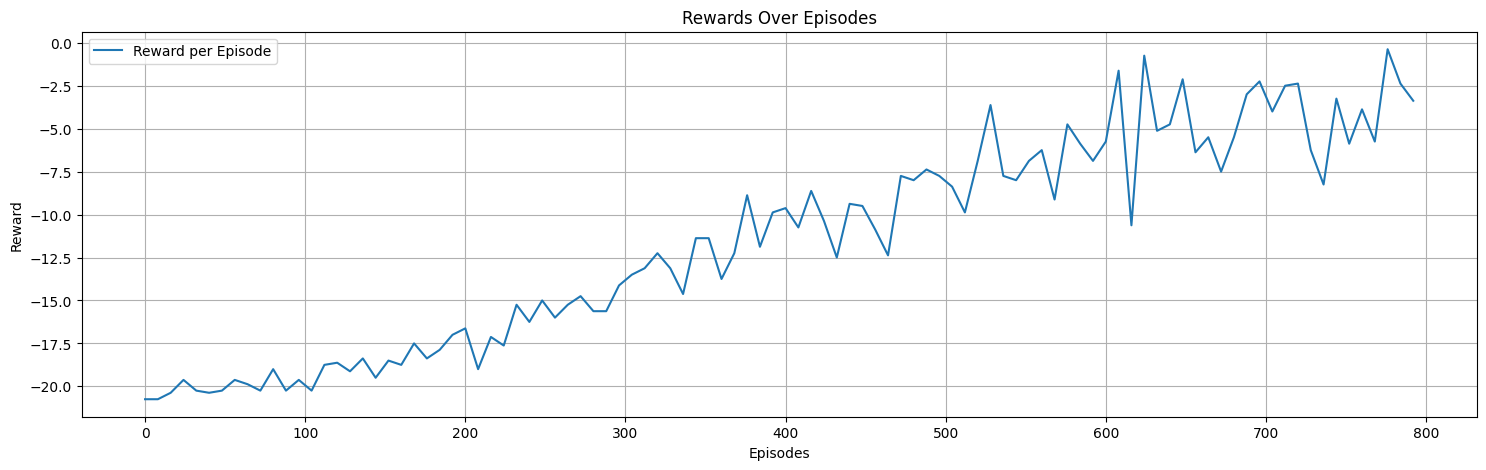

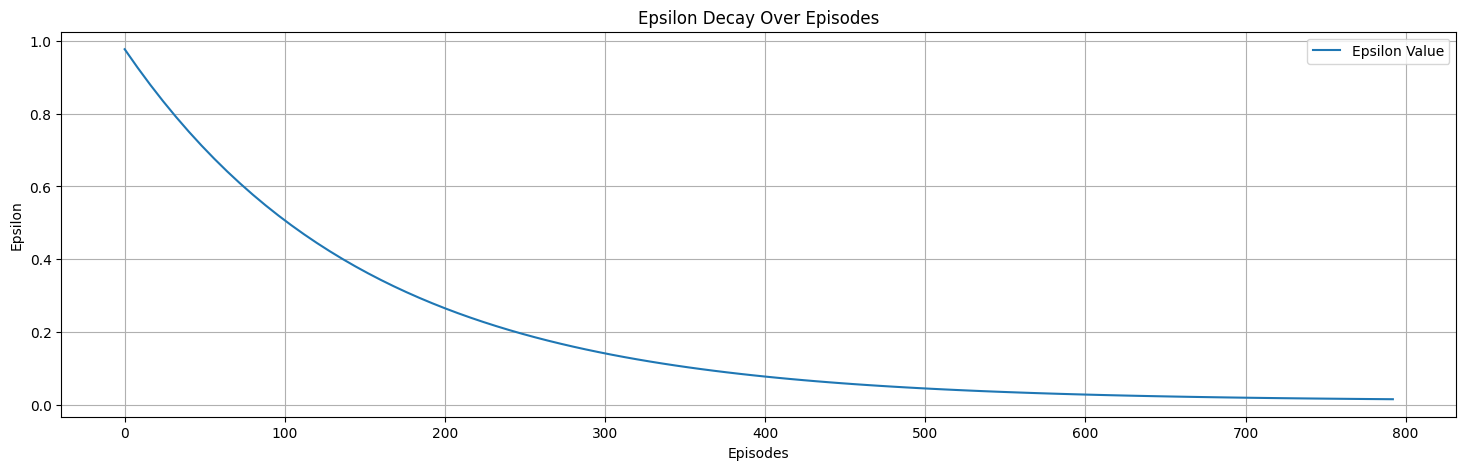

In [ ]:
plot_rewards_over_episodes(reward_list)
plot_epsilon_over_episodes(epsilon_list)

In [ ]:
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt
from itertools import count

def test_and_plot_rewards(env, policy_net, n_episodes):
    policy_net.eval()

    episode_rewards = []

    for episode in range(n_episodes):
        obs = env.reset()
        state = get_state(obs)

        total_reward = 0.0
        for t in count():
            with torch.no_grad():
                action = policy_net(state).max(1)[1].view(1, 1).item()

            obs, reward, truncated, terminated, _ = env.step(action)
            total_reward += reward
            if not terminated and not truncated:
                next_state = get_state(obs)
            else:
                next_state = None

            state = next_state

            if terminated or truncated:
                break

        episode_rewards.append(total_reward)
        print(f"Finished Episode {episode} with reward {total_reward}")

    plt.figure(figsize=(10, 5))
    plt.plot(episode_rewards, marker='o', linestyle='-')
    plt.title('Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.show()


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


Finished Episode 0 with reward -6.0
Finished Episode 1 with reward 4.0
Finished Episode 2 with reward 1.0
Finished Episode 3 with reward 12.0
Finished Episode 4 with reward -5.0
Finished Episode 5 with reward 4.0
Finished Episode 6 with reward -4.0
Finished Episode 7 with reward -1.0
Finished Episode 8 with reward -10.0
Finished Episode 9 with reward 10.0


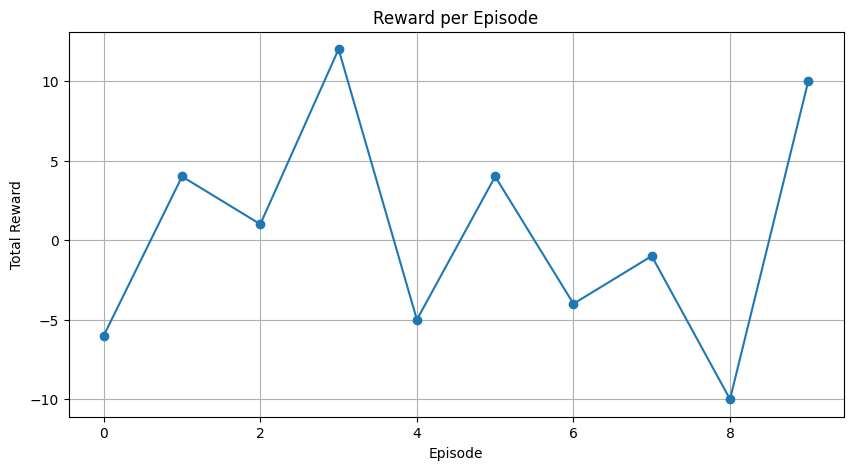

In [ ]:
device = 'cuda'
env = gym.make("ALE/Pong-v5", new_step_api=True)
env = make_env(env)
policy_net.to(device)
test_and_plot_rewards(env, policy_net, 10)

In [ ]:
!mkdir models

In [ ]:
# Saving the model
import os
from google.colab import files

save_directory = "/content/models"
model_filename = "pong_policy_model.pth"

model_path = os.path.join(save_directory, model_filename)

torch.save(policy_net.state_dict(), model_path)
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Implementing DDQN for Pong

import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from itertools import count

# Initialize environment
envBase = gym.make("ALE/Pong-v5", new_step_api=True)
env = make_env(envBase)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize networks
policy_net = PongCNN(action_space=env.action_space.n).to(device)
target_net = PongCNN(action_space=env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# Optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)

# Replay buffer
replay_buffer = ReplayBuffer(50000)

# Training parameters
num_episodes = 800
batch_size = 64
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 150
target_update = 4

# Epsilon decay function
def epsilon_by_episode(episode):
    return epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * episode / epsilon_decay)

# Compute TD Loss for DDQN
def compute_td_loss_ddqn(policy_net, target_net, experiences, gamma, device):
    states, actions, rewards, next_states, dones = experiences

    state_action_values = policy_net(states).gather(1, actions.unsqueeze(1))

    next_state_values = torch.zeros(batch_size, device=device)
    next_state_actions = policy_net(next_states).argmax(dim=1).unsqueeze(1)
    next_state_values[dones == False] = target_net(next_states[dones == False]).gather(1, next_state_actions[dones == False]).squeeze()

    expected_state_action_values = (next_state_values * gamma) + rewards

    loss = nn.MSELoss()(state_action_values, expected_state_action_values.unsqueeze(1))
    return loss


all_episode_rewards = []
epsilons_over_time = []
total_timesteps = 0

for episode in range(num_episodes):
    state = env.reset()
    epsilon = epsilon_by_episode(episode)
    epsilons_over_time.append(epsilon)
    episode_rewards = 0

    for t in count():
        if random.random() > epsilon:
            policy_net.eval()
            with torch.no_grad():
                state_np = np.array(state, dtype=np.float32)
                state_tensor = torch.tensor(state_np, device=device).unsqueeze(0)
                state_tensor = transform_states(state_tensor)
                action_values = policy_net(state_tensor)
                action = action_values.max(1)[1].view(1, 1)
        else:
            action = torch.tensor([[random.randrange(env.action_space.n)]], device=device, dtype=torch.long)

        policy_net.train()

        next_state, reward, terminated, truncated, _ = env.step(action.item())
        episode_rewards += reward

        replay_buffer.add(state, action.item(), reward, next_state, terminated or truncated)
        state = next_state

        if len(replay_buffer) > batch_size:
            experiences = replay_buffer.sample(batch_size, device)
            loss = compute_td_loss_ddqn(policy_net, target_net, experiences, gamma, device)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=1.0)
            optimizer.step()

        if terminated or truncated:
            total_timesteps += t + 1
            print(f'Episode {episode} finished after {t+1} timesteps with reward {episode_rewards}. Epsilon: {epsilon:.2f}')
            all_episode_rewards.append(episode_rewards)
            break

    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

torch.save(policy_net, "pong_model_ddqn.pth")


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


Episode 0 finished after 293 timesteps with reward -18.0. Epsilon: 1.00
Episode 1 finished after 251 timesteps with reward -19.0. Epsilon: 0.99
Episode 2 finished after 244 timesteps with reward -21.0. Epsilon: 0.99
Episode 3 finished after 214 timesteps with reward -21.0. Epsilon: 0.98
Episode 4 finished after 214 timesteps with reward -21.0. Epsilon: 0.97
Episode 5 finished after 225 timesteps with reward -20.0. Epsilon: 0.97
Episode 6 finished after 207 timesteps with reward -21.0. Epsilon: 0.96
Episode 7 finished after 226 timesteps with reward -20.0. Epsilon: 0.95
Episode 8 finished after 221 timesteps with reward -21.0. Epsilon: 0.95
Episode 9 finished after 207 timesteps with reward -21.0. Epsilon: 0.94
Episode 10 finished after 249 timesteps with reward -21.0. Epsilon: 0.94
Episode 11 finished after 227 timesteps with reward -20.0. Epsilon: 0.93
Episode 12 finished after 241 timesteps with reward -20.0. Epsilon: 0.92
Episode 13 finished after 218 timesteps with reward -20.0. Ep

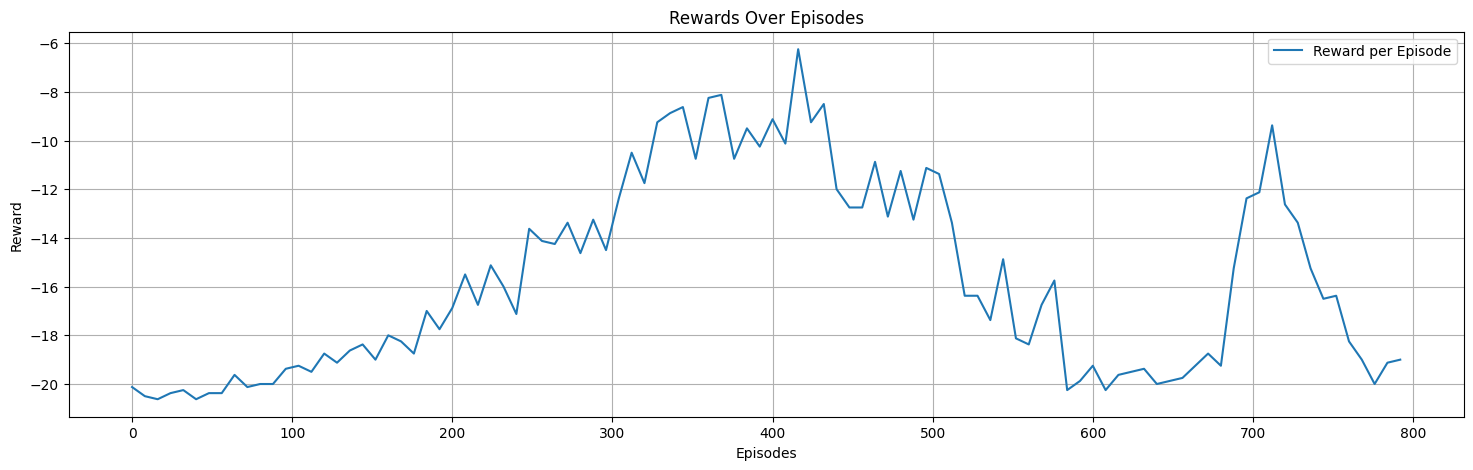

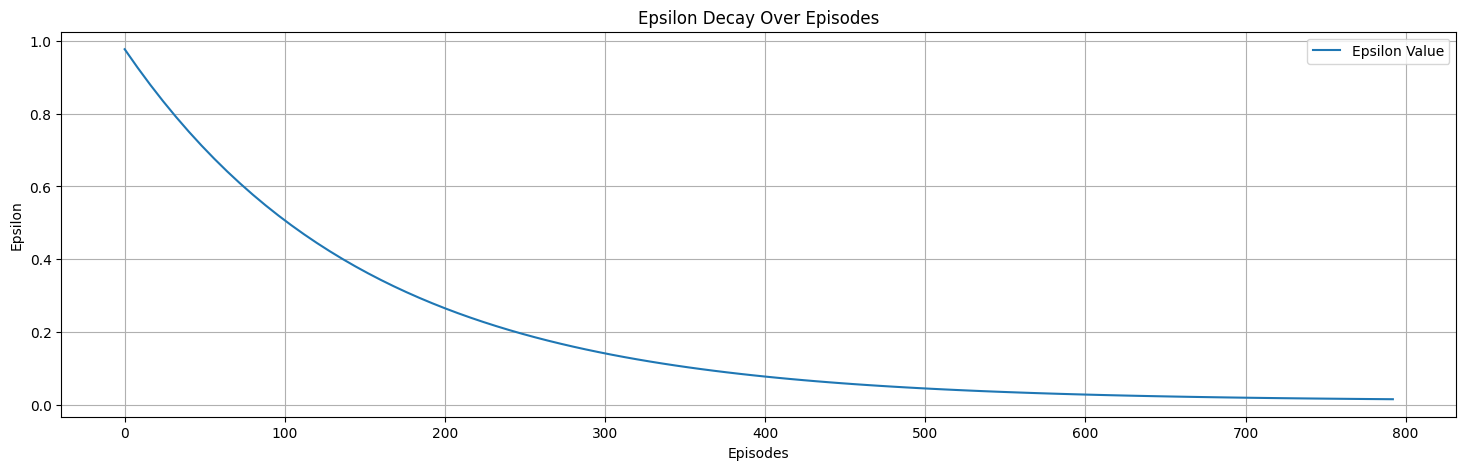

In [ ]:
plot_rewards_over_episodes(all_episode_rewards)
plot_epsilon_over_episodes(epsilon_list)

Finished Episode 0 with reward -18.0
Finished Episode 1 with reward -17.0
Finished Episode 2 with reward -20.0
Finished Episode 3 with reward -20.0
Finished Episode 4 with reward -15.0
Finished Episode 5 with reward -19.0
Finished Episode 6 with reward -18.0
Finished Episode 7 with reward -17.0
Finished Episode 8 with reward -20.0
Finished Episode 9 with reward -19.0


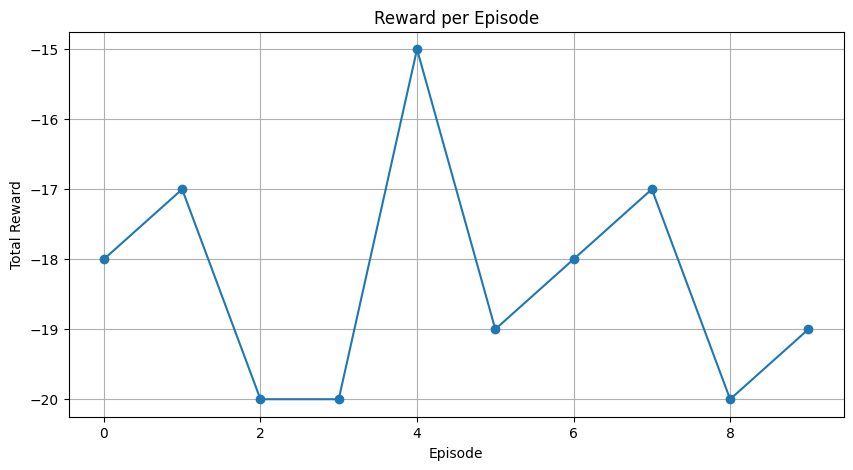

In [ ]:
device = 'cuda'
env = gym.make("ALE/Pong-v5", new_step_api=True)
env = make_env(env)
policy_net.to(device)
test_and_plot_rewards(env, policy_net, 10)

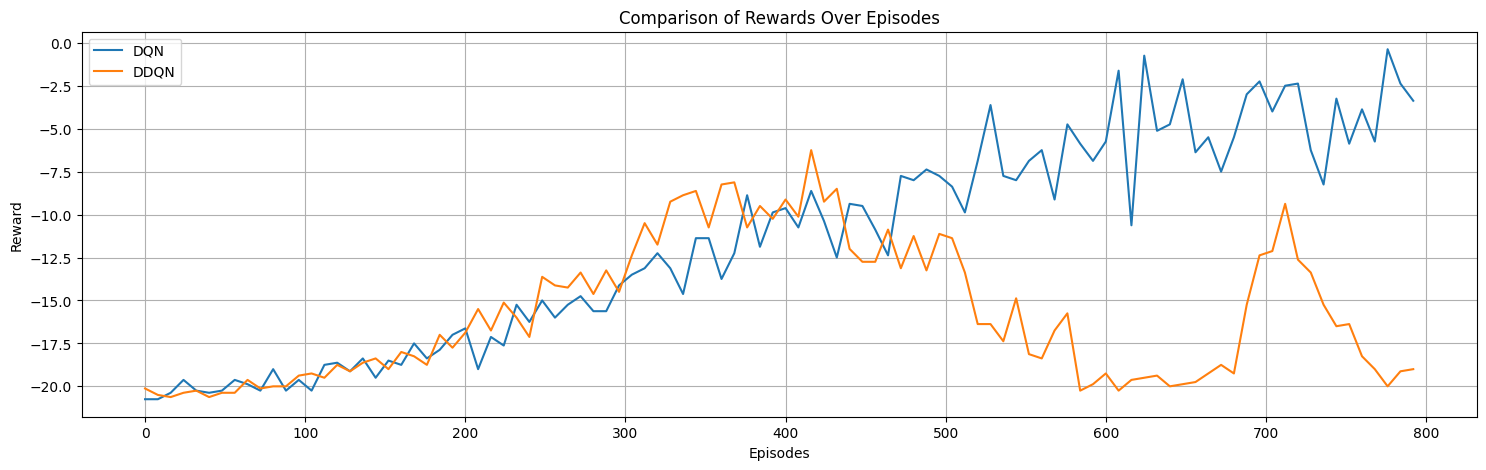

In [ ]:
plot_two_rewards_over_episodes(reward_list, all_episode_rewards, labels=('DQN', 'DDQN'))